In [31]:
import json
from matplotlib.font_manager import json_dump
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pylab as plt
import os
  

sf_data = []
vicon_data = []
dataset_name = "test_run2"
path_sf = "/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/sensorfloor_measurement/28102022"
file_name_sf = "sensor_floor_data_28102022_" + dataset_name + ".txt"

os.chdir(path_sf)

#for line in open("../Dataset_sensor_floor/sensorfloor_measurement/16092022/sensor_floor_data_16092022_" + dataset_name + ".txt", "r"):
#for line in open("../../../media/irfan-flw/OS/Arbeit/6GEM/Program_Development/6GEM_Dataset/sensorfloor_measurement/16092022/sensor_floor_data_16092022_" + dataset_name + ".txt", "r"):
for line in open(file_name_sf, "r"):
    sf_data.append(json.loads(line))

df_sf = pd.DataFrame(sf_data)
df_sf

,timestamp,strip_id,node_id,data,column_num
0,1.666968e+09,4,8,"[{'a': [0.0595703125, 0.151611328125, 1.035644...",4
1,1.666968e+09,5,12,"[{'a': [0.06689453125, 0.116455078125, 0.99707...",5
2,1.666968e+09,8,8,"[{'a': [0.048095703125, 0.084228515625, 1.0119...",8
3,1.666968e+09,11,7,"[{'a': [0.021484375, 0.136474609375, 1.0627441...",11
4,1.666968e+09,12,10,"[{'a': [0.052978515625, 0.1279296875, 1.065917...",12
...,...,...,...,...,...
7278,1.666969e+09,17,5,"[{'a': [0.060302734375, 0.1884765625, 1.055175...",17
7279,1.666969e+09,13,3,"[{'a': [0.01220703125, 0.148681640625, 1.03784...",13
7280,1.666969e+09,7,1,"[{'a': [0.0673828125, 0.10595703125, 1.0593261...",7
7281,1.666969e+09,3,9,"[{'a': [0.034912109375, 0.140869140625, 1.0317...",3


## Build the dataframe of sensor floors ##

***Timestamp Interpolation***

In [32]:
#test timestamp interpolation
#t_batch_i_now = np.zeros((23,15))
t_batch_i_old = np.zeros((23,15))
df_sf_buf = df_sf.copy()


#df_sf_buf = df_sf_buf.reindex(df_sf_buf.columns.tolist() + ['ax','ay','az','gx','gy','gz','mx','my','mz','rssi'], axis=1) 
out = []
for index, row in df_sf_buf.T.items():
    index_strip_id = int(df_sf_buf['strip_id'][index])
    index_node_id = int(df_sf_buf['node_id'][index])
    #print('t_batch: ', df_sf_buf['timestamp'][index])
    #t_batch_i_now[index_strip_id][index_node_id] = df_sf_buf['timestamp'][index]
    #print(t_batch_i_old[index_strip_id-1][index_node_id-1])
    delta_t = 0
    timestamp_i = 0

    for i in range(len(df_sf_buf['data'][index])):

        #check timestamp
        if t_batch_i_old[index_strip_id-1][index_node_id-1] < df_sf_buf['timestamp'][index] and t_batch_i_old[index_strip_id-1][index_node_id-1] > 0:
            delta_t = (df_sf_buf['timestamp'][index] - t_batch_i_old[index_strip_id-1][index_node_id-1])/len(df_sf_buf['data'][index])
            
            t_i = t_batch_i_old[index_strip_id-1][index_node_id-1] + ((1+i)*delta_t)
            if df_sf_buf['data'][index][i]['r'][0] < 0:
                #print('iter > 0: ', delta_t)
                out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':df_sf_buf['data'][index][i]['r'][0],'timestamp':t_i})
            else:
                out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':np.nan,'timestamp':t_i})
                #print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
            # t_batch_i_old[index_strip_id-1][index_node_id-1] = df_sf_buf['timestamp'][index]

        elif t_batch_i_old[index_strip_id-1][index_node_id-1] == 0:
            delta_t = 4/19
            #print('iter 0: ', delta_t)
            t_i = (df_sf_buf['timestamp'][index]-4) + ((1+i)*delta_t)
            if df_sf_buf['data'][index][i]['r'][0] < 0:
                #print(t_i)
                out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':df_sf_buf['data'][index][i]['r'][0],'timestamp':t_i})
            else:
                out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':np.nan,'timestamp':t_i})
            #print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
            t_first = (df_sf_buf['timestamp'][index]) - 4           
            t_batch_i_old[index_strip_id-1][index_node_id-1] = t_first
            #print(t_batch_i_old[index_strip_id-1][index_node_id-1])
    
    
    t_batch_i_old[index_strip_id-1][index_node_id-1] = df_sf_buf['timestamp'][index]    
    #print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
        

df_sf_final = pd.DataFrame(out)
del(out)
df_sf_final

,strip_id,node_id,ax,ay,az,gx,gy,gz,mx,my,mz,r,timestamp
0,4,8,0.059570,0.151611,1.035645,0.190840,1.015267,0.083969,42.75,-53.85,189.60,-81.0,1.666968e+09
1,4,8,0.058350,0.146973,1.039795,0.297710,1.167939,0.083969,45.90,-54.60,189.60,-82.0,1.666968e+09
2,4,8,0.059082,0.147461,1.043457,0.175573,1.083969,0.114504,44.55,-52.50,190.95,-82.0,1.666968e+09
3,4,8,0.060791,0.146973,1.040527,0.519084,1.083969,0.175573,43.20,-54.00,188.70,-81.0,1.666968e+09
4,4,8,0.061768,0.149170,1.037598,0.175573,0.992366,0.381679,44.70,-53.70,190.05,-82.0,1.666968e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137509,20,14,0.047119,0.118652,1.054688,-0.770992,0.549618,0.748092,-78.00,0.60,22.80,-78.0,1.666969e+09
137510,20,14,0.042969,0.120361,1.060303,-0.320611,0.229008,0.618321,-77.70,1.05,21.15,-77.0,1.666969e+09
137511,20,14,0.042725,0.115967,1.051514,-0.580153,0.320611,0.748092,-76.65,-0.45,21.15,-77.0,1.666969e+09
137512,20,14,0.042969,0.117676,1.058350,-0.603053,0.396947,0.778626,-78.45,1.05,22.50,-77.0,1.666969e+09


In [33]:
df_sf_final = df_sf_final.sort_values(['timestamp'])
df_sf_final = df_sf_final.reset_index(drop=True)
df_sf_final

,strip_id,node_id,ax,ay,az,gx,gy,gz,mx,my,mz,r,timestamp
0,4,8,0.059570,0.151611,1.035645,0.190840,1.015267,0.083969,42.75,-53.85,189.60,-81.0,1.666968e+09
1,5,12,0.066895,0.116455,0.997070,-1.442748,0.618321,0.618321,88.05,-19.95,-220.35,NaN,1.666968e+09
2,8,8,0.048096,0.084229,1.011963,-0.442748,0.954198,-0.091603,-180.30,0.15,153.00,NaN,1.666968e+09
3,11,7,0.021484,0.136475,1.062744,-2.076336,1.671756,1.969466,-201.00,79.50,14.10,-88.0,1.666968e+09
4,12,10,0.052979,0.127930,1.065918,-1.244275,1.770992,0.954198,36.90,-57.75,5.10,-82.0,1.666968e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137509,17,5,0.057861,0.191895,1.052246,-0.648855,1.595420,0.709924,43.50,36.00,11.85,-82.0,1.666969e+09
137510,13,3,0.010742,0.151611,1.040527,-2.206107,2.145038,1.519084,-64.05,-90.90,-29.85,-79.0,1.666969e+09
137511,7,1,0.070557,0.109619,1.052002,0.687023,0.641221,2.862595,95.85,252.60,42.75,-81.0,1.666969e+09
137512,3,9,0.036377,0.138916,1.033936,-1.854962,1.198473,1.091603,-2.25,39.15,104.70,-74.0,1.666969e+09


**Build Dataset of VICON Coordinates**

In [34]:
#DATASET OF VICON COORDINATES
#for line in open("../Dataset_sensor_floor/vicon_measurement/16092022/vicon_data_16092022_" + dataset_name + ".txt", "r"):
path_vicon = "/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/vicon_measurement/28102022"
file_name_vicon = "vicon_data_28102022_" + dataset_name + ".txt"

os.chdir(path_vicon)

for line in open(file_name_vicon, "r"):
    vicon_data.append(json.loads(line))

df_vicon = pd.DataFrame(vicon_data)
#df_vicon['time'] = pd.to_datetime(df_vicon['time'],unit='s')
df_vicon.shape

(23225, 4)

In [35]:
df_vicon_buf = df_vicon.copy()
df_vicon_buf = df_vicon_buf.reindex(df_vicon_buf.columns.tolist() + ['X','Y'], axis=1) 

for index, row in df_vicon_buf.T.items():
    for i in range(len(df_vicon_buf['translation'][index])):
        #print((test_df['data'][index][i]['r']))
        df_vicon_buf.loc[index,'X'] = df_vicon_buf['translation'][index][0]
        df_vicon_buf.loc[index,'Y'] = df_vicon_buf['translation'][index][1]

df_vicon_buf = df_vicon_buf.drop(columns=['object','translation','rotation'])
#df_vicon_buf

***Filter and Resample Vicon Data***

In [36]:
df_vicon_resample = df_vicon_buf.copy()
df_vicon_resample['time_resample'] = pd.to_datetime(df_vicon_resample['time'],unit='s')
#df_vicon_resample['time'] = df_vicon_resample['time'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f'))
df_vicon_resample = df_vicon_resample.set_index('time_resample')
df_vicon_final = df_vicon_resample.resample('40ms').ffill()
df_vicon_final = df_vicon_final.dropna()
df_vicon_final = df_vicon_final.sort_values(['time'])
df_vicon_final = df_vicon_final.reset_index(drop=True)
df_vicon_final

,time,X,Y
0,1.666968e+09,-2.594851,-3.024108
1,1.666968e+09,-2.594833,-3.024096
2,1.666968e+09,-2.594830,-3.024118
3,1.666968e+09,-2.594846,-3.024086
4,1.666968e+09,-2.594852,-3.024092
...,...,...,...
2913,1.666969e+09,-3.106980,-3.596107
2914,1.666969e+09,-3.106931,-3.596104
2915,1.666969e+09,-3.106929,-3.596116
2916,1.666969e+09,-3.106950,-3.596101


**CREATE ARRAY OF RSSI & VICON COORDINATES**

In [37]:
from turtle import width
import matplotlib.animation as animation
%matplotlib ipympl
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#CREATE DATASET FOR SENSOR FLOOR ARRAY
x_sf = df_sf_final['strip_id'].to_numpy()
y_sf = df_sf_final['node_id'].to_numpy()
z_sf = df_sf_final['r'].to_numpy()
t_sf = df_sf_final['timestamp'].to_numpy()
dataSet_sf = np.array([x_sf, y_sf, z_sf, t_sf])
numDataPoints_sf = len(t_sf)
num_of_nodes = 15
num_of_strips = 23

delta_t_sf = round((t_sf.max()-t_sf.min())/numDataPoints_sf, 6)

print('dataset sf: ', dataSet_sf.shape)

#-------------------------------------------------------------------------------------------------------------------#

#CREATE DATASET FOR VICON COORDINATES
t_vc = df_vicon_final['time'].to_numpy()
x_vc = df_vicon_final['X'].to_numpy()
y_vc = df_vicon_final['Y'].to_numpy()
dataSet_vc = np.array([x_vc, y_vc, t_vc])
numDataPoints_vc = len(t_vc)

delta_t_vc = round((t_vc.max()-t_vc.min())/numDataPoints_vc, 6)

print("dataset vc:", dataSet_vc.shape)

#numDataPoints_vc = dataSet_vc.shape[1]
# print("dataset vc:",dataSet_vc.shape)
# print(dataSet_vc)

#-------------------------------------------------------------------------------------------------------------------#
#Check the index of closest timestamp to Vicon Dataset

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    #print(np.abs(array - value), len(np.abs(array - value)))
    return idx

#timestamp_merge_arr = [t_vc[idx]+delta_t_vc for idx, x in enumerate(t_vc)]
# index_low_vc = find_nearest(dataSet_vc[2], threshold_sf_low)
# index_low_X = find_nearest(dataSet_sf[3], dataSet_vc[2][index_low_vc])
#timestamp_merge_arr_filter = [t_vc[idx]+delta_t_vc for idx, x in enumerate(t_vc) if idx > index_low_vc-1]


#closest_index_vicon = []
closest_index_sf = []

#for i in range(len(timestamp_merge_arr)):
for i in range(numDataPoints_vc):
    pos = t_vc[i]
    #index_vicon = find_nearest(dataSet_vc[2], pos)
    index_sf = find_nearest(dataSet_sf[3], pos)

    #closest_index_vicon.append(index_vicon)
    closest_index_sf.append(index_sf)

print(len(closest_index_sf), closest_index_sf)

dataset sf:  (4, 137514)
dataset vc: (3, 2918)
2918 [14604, 14659, 14716, 14774, 14833, 14886, 14948, 15003, 15062, 15116, 15175, 15233, 15288, 15345, 15405, 15461, 15516, 15580, 15632, 15688, 15750, 15804, 15865, 15919, 15976, 16030, 16089, 16149, 16207, 16260, 16320, 16376, 16435, 16490, 16547, 16605, 16661, 16721, 16778, 16832, 16893, 16950, 17006, 17057, 17119, 17183, 17232, 17290, 17344, 17404, 17454, 17519, 17579, 17634, 17690, 17752, 17801, 17866, 17921, 17974, 18034, 18091, 18152, 18207, 18262, 18321, 18375, 18434, 18491, 18551, 18606, 18662, 18721, 18779, 18836, 18891, 18946, 19003, 19062, 19121, 19178, 19234, 19292, 19349, 19404, 19465, 19522, 19579, 19628, 19694, 19751, 19806, 19864, 19920, 19976, 20035, 20092, 20148, 20177, 20266, 20322, 20378, 20439, 20497, 20549, 20607, 20664, 20718, 20776, 20837, 20892, 20949, 21008, 21064, 21122, 21182, 21235, 21294, 21349, 21406, 21466, 21520, 21577, 21634, 21693, 21750, 21806, 21863, 21921, 21976, 22040, 22098, 22151, 22209, 22270, 22

**CREATE FRAME FOR MERGED DATASET**

In [38]:
#CREATE ARRAY FOR DATA SENSORS
#from asyncio.windows_events import NULL
from tqdm import tqdm_notebook as tqdm

path = "/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter"
os.chdir(path)

KEYS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'r', 'timestamp']
Vicon_Coords = pd.read_csv("vicon_node_positions.csv")
df_data = Vicon_Coords[['strip_id','node_id']]
df_data = df_data.astype('int32')

X = np.zeros([len(closest_index_sf), 23, 15, 11])
t = np.zeros([len(closest_index_sf), 1])
frames = []
dataSet_vc_X = []
dataSet_vc_Y = []
dataSet_vc_t = []
cnt = 0
X_i = np.zeros([23, 15, 11])

for index, row in tqdm(df_sf_final.T.items(), total=len(df_sf_final)):

    df_i = row

    for i, key in enumerate(KEYS):
        X_i[int(df_i.strip_id) - 1, int(df_i.node_id) - 1, i] = df_i[key]
    
    X_df = X_i.reshape([345,11])
    df_X = pd.DataFrame(X_df, columns=KEYS)
    df_data[['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'r', 'timestamp']] = df_X
    frame_i = df_data.to_json(orient='columns')
    
    t_i = df_i.timestamp

    # X[index] = X_i
    # t[index] = t_i
    #frames.insert(index, frame_i)
    frame_bool = df_data.empty
    #print(frame_bool)

    if index in closest_index_sf and not frame_bool:
       
        #print(df_data)
        index_assoc = closest_index_sf.index(index)
        #print(cnt, index, index_assoc)
        frames.append(frame_i)
        #frames[cnt] = frame_i
        X[cnt] = X_i
        t[cnt] = t_i
        dataSet_vc_X.append(dataSet_vc[0,index_assoc])
        dataSet_vc_Y.append(dataSet_vc[1,index_assoc])
        dataSet_vc_t.append(dataSet_vc[2,index_assoc])
        #dataSet_vc_final.append(dataSet_vc[:,index_assoc])
        #print(dataSet_vc[0,index_assoc],dataSet_vc[1,index_assoc],dataSet_vc[2,index_assoc])

        # frames[index_assoc] = frame_i
        # X[index_assoc] = X_i
        # t[index_assoc] = t_i
        cnt += 1
    #print(index,'/',len(df_sf_final))

dataSet_vc_final = np.array([dataSet_vc_X, dataSet_vc_Y, dataSet_vc_t])
print(X.shape, t.shape, len(frames), dataSet_vc_final.shape)

/tmp/ipykernel_7165/1038063659.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df_sf_final.T.items(), total=len(df_sf_final)):


  0%|          | 0/137514 [00:00<?, ?it/s]

(2918, 23, 15, 11) (2918, 1) 2917 (3, 2917)


**Check index of timestamp threshold**

In [39]:
sensor_data_final = X[:cnt-1]
t_data_final = t[:cnt-1]
frames_final = frames[:cnt-1]

#dataSet_vc_final = dataSet_vc[:,:]
dataSet_vc_final = dataSet_vc_final[:,:-1]
dataSet_vc_final = np.transpose(dataSet_vc_final)

#print(index_low_X, t[index_low_X] , index_low_vc, dataSet_vc[2][index_low_vc])
print(sensor_data_final.shape, t_data_final.shape, len(frames_final), dataSet_vc_final.shape)

(2916, 23, 15, 11) (2916, 1) 2916 (2916, 3)


**MERGE RSSI HEATMAP & VICON COORDINATES WITH SLIDER**

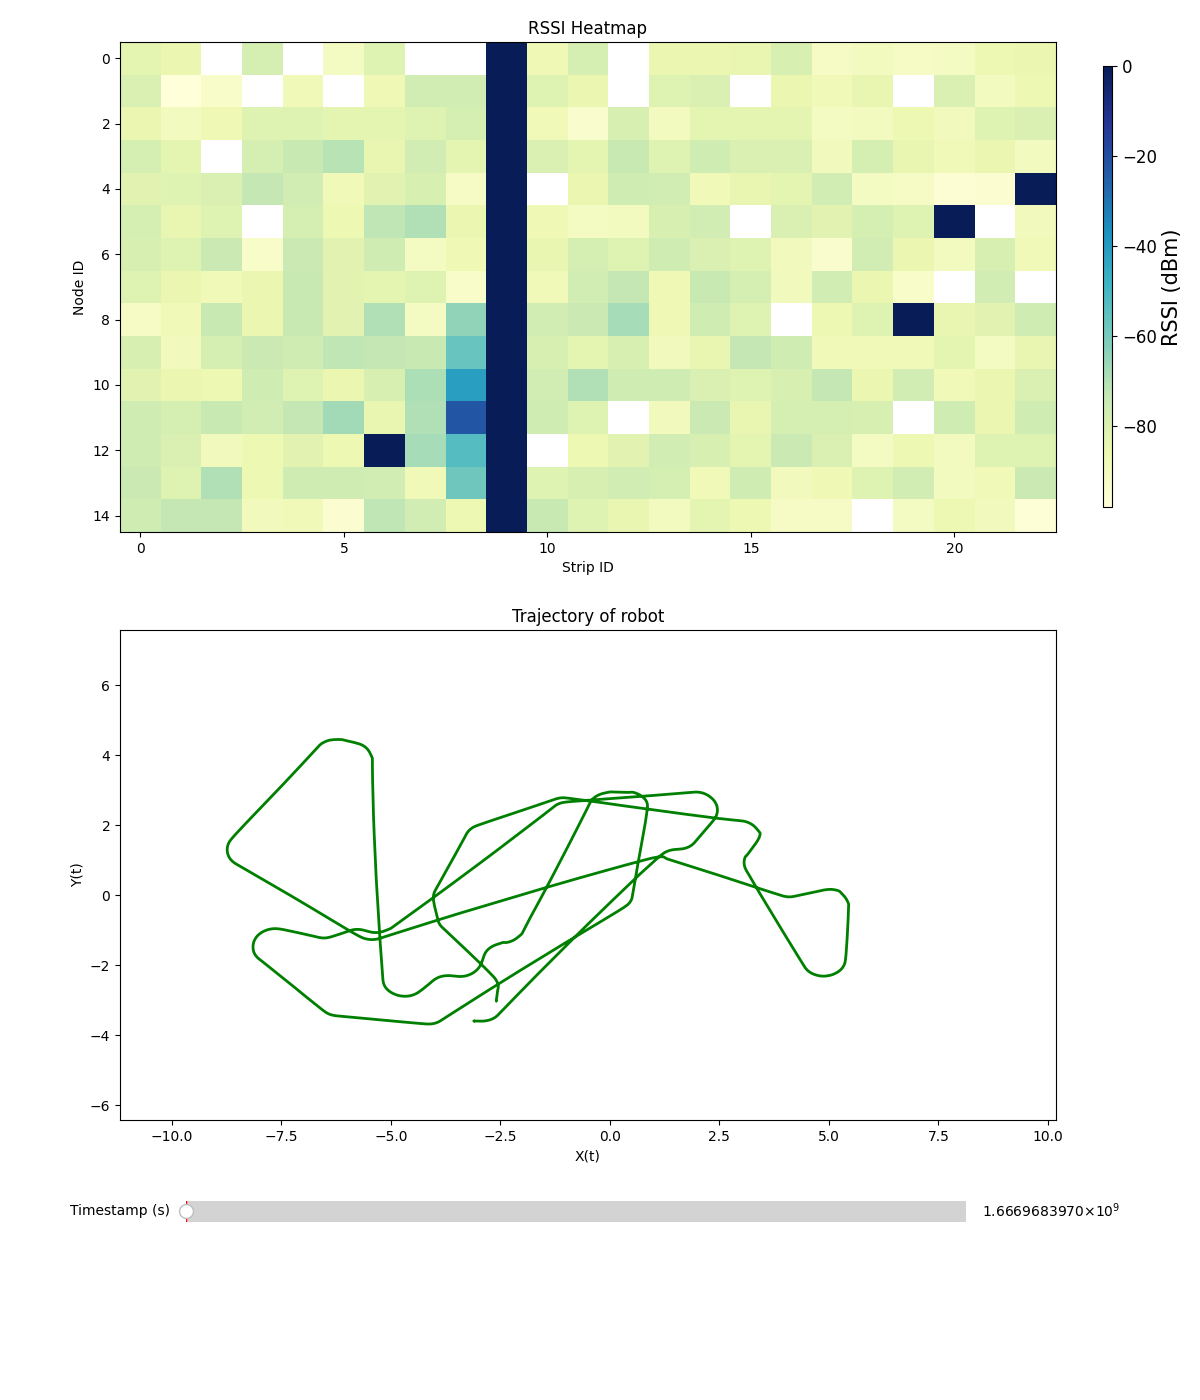

In [40]:
#MERGE RSSI HEATMAP & VICON COORDINATES WITH SLIDER

rssi_data = sensor_data_final[:,:,:,9]
rssi_data_transpose = np.transpose(rssi_data, [0,2,1])

numdataPoints = len(dataSet_vc_final)

# GET SOME MATPLOTLIB OBJECTS
#fig, (ax1, ax2) = plt.subplots(figsize=(10,12), nrows=2)
fig = plt.figure(figsize=(12,14))
plt.subplots_adjust(bottom=0.25)

# AXES PROPERTIES RSSI HEATMAP
ax1 = fig.add_subplot(211) #(row, column, pos)
#ax1.set_autoscale_on
ax1.set_xlabel('Strip ID')
ax1.set_ylabel('Node ID')
ax1.set_title('RSSI Heatmap')

# # AXES PROPERTIES VICON COORDINATES
ax2 = fig.add_subplot(212)
ax2.set_xlim(-11.185, 10.185)
ax2.set_ylim(-6.425, 7.575)
ax2.set_xlabel('X(t)')
ax2.set_ylabel('Y(t)')
ax2.set_title('Trajectory of robot')


# Defining the Slider button
# xposition, yposition, width and height
# ax_slide_sf = plt.axes([0.155, 0.02, 0.65, 0.03])
# ax_slide_vc = plt.axes([0.155, 0.07, 0.65, 0.03])
ax_slide_merge = plt.axes([0.155, 0.12, 0.65, 0.03])


#DISPLAY INITIAL IMAGE
im_h = ax1.imshow(rssi_data_transpose[numdataPoints-1], cmap="YlGnBu", aspect='auto')
axins = inset_axes(ax1,
                   width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 1.25, 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )
cbar = plt.colorbar(im_h, cax=axins, ax=ax1)
cbar.set_label(label='RSSI (dBm)', size=15)
cbar.ax.tick_params(labelsize=12)


#cbar.ax.set_axes_locator
# #cbar.set_ticks()

line = ax2.plot(dataSet_vc_final[:,0], dataSet_vc_final[:,1], lw=2, c='g')[0] # For line plot

# Properties of the slider

#normal data
timestamp_merge = Slider(ax_slide_merge, 'Timestamp (s)',
                  t_vc.min(), t_vc.max(), valinit=t_vc.min(), valstep=delta_t_vc)

 

def update_all(val):
    pos = timestamp_merge.val
    #print(pos)
    index = find_nearest(dataSet_vc_final[:,2], pos)
    line.set_xdata(dataSet_vc_final[:index,0])
    line.set_ydata(dataSet_vc_final[:index,1])

    #index2 = find_nearest(dataSet_sf[3], dataSet_vc_final[2][index])
    im_h.set_data(rssi_data_transpose[index])

    #redrawing the figure
    fig.canvas.draw() 

# Calling the function "update" when the value of the slider is changed

timestamp_merge.on_changed(update_all)

#fig.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.88, top=0.97, hspace=0.2)
#plt.subplots_adjust(left=0.155, bottom=0.2, right=0.91, top=0.97, hspace=0.2)
#plt.subplot_tool()
plt.show()

In [25]:
home_path = '/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/output/plot_img'
os.chdir(home_path)
plt.savefig(dataset_name + '_test_run_2810.png', dpi=300)

In [41]:
#MERGE DATASET

#dataSet_vc_final = np.transpose(dataSet_vc_final)
frame_number = np.empty(dataSet_vc_final.shape[0], dtype=object)
frame_data = np.empty(dataSet_vc_final.shape[0], dtype=object)
frame_count = 0
for row in range(dataSet_vc_final.shape[0]):
    time_vc = dataSet_vc_final[row][2]
    #time_vc = dataSet_vc[2][row]
    #index_vc = closest_timestamp(dataSet_vc[2], time_vc)
    #index_sf = closest_timestamp(t_data_final, time_vc)

    frame_number[row] = str(frame_count)
    frame_data[row] = frames_final[row]
    frame_count += 1

**GENERATES THE DATASET AS .CSV FILE**

In [14]:
array_frame_vc = dataSet_vc_final.astype(object)

dataSet_final = np.array([frame_number, array_frame_vc[:,0], array_frame_vc[:,1], frame_data])
dataSet_final = np.transpose(dataSet_final)
#dataSet_final.shape
frame_sf = pd.DataFrame(dataSet_final, columns=['frame_number','vicon_x','vicon_y','data'])

path_dataset = '/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/24102022/'

os.chdir(path_dataset)

frame_sf.to_csv(r'/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/24102022/' +  dataset_name + '.csv', index=False)

#data_dir = '../Dataset_sensor_floor/Dataset_Final/30092022/'
#csv_name = data_dir + 'dataset_3009022_' + dataset_name + '.csv'
# csv_name = path_dataset + dataset_name + '.csv'
# frame_sf.to_csv(csv_name, index=False)
#dataSet_final

**GENERATES TEST DATASET AS .CSV FILE**

In [42]:
array_frame_vc = dataSet_vc_final.astype(object)

test_dataset = np.array([frame_number, frame_data])
test_dataset = np.transpose(test_dataset)

ground_truth = np.array([frame_number, array_frame_vc[:,2], array_frame_vc[:,0], array_frame_vc[:,1]])
ground_truth = np.transpose(ground_truth)

frame_test = pd.DataFrame(test_dataset, columns=['frame_number','data'])
frame_ground_truth = pd.DataFrame(ground_truth, columns=['frame_number','time','vicon_x','vicon_y'])

path_dataset = '/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/24102022/'

os.chdir(path_dataset)

frame_test.to_csv(r'/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/28102022/' +  dataset_name + '.csv', index=False)
frame_ground_truth.to_csv(r'/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/28102022/' +  dataset_name + '_gt.csv', index=False)

In [29]:
array_frame_vc[:,2]

array([1666968708.1171885, 1666968708.1525083, 1666968708.1973977, ...,
       1666968796.0787764, 1666968796.1169202, 1666968796.156892],
      dtype=object)

**Store the data to pickle**

In [15]:
import pickle

data_pickle_file = 'pickle/' + dataset_name + '_24102022.pkl'

# write data
pickle_data = [sensor_data_final, dataSet_vc_final, t_data_final]
with open(data_pickle_file, 'wb') as handle:
    pickle.dump(pickle_data, handle, protocol=3)
print('Successfully stored!')

Successfully stored!
